In [1]:
# model implementation
from ml.models.clustering import KNN
from ml.functions.distance import EuclideanDistance, MahalanobisDistance

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(20)

## Load dataset

In [2]:
# X, y = load_csv('./datasets/kc2.csv', remove_duplicates=True, remove_inconsistent_labels=True)
X, y = load_csv('./datasets/kc2.csv')

y = y.astype(int).squeeze()
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

## Q1 a,b - K-Nearest Neighbors (KNN)

### Grid search with 10-fold cross-validation - hyperparameters K=[1, 5] and distance=['Euclidean', 'Mahalanobis']

In [3]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for k in [1, 5]:
    for distance in [EuclideanDistance, MahalanobisDistance]:
        grid.add(KNN, {"k": k, "distance": distance, "data_scaler": MinMaxScaler})

grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best KNN:", grid.best_model_params)

Best KNN: {'k': 5, 'distance': <class 'ml.functions.distance.EuclideanDistance'>, 'data_scaler': <class 'ml.algorithms.normalization.MinMaxScaler'>}


### Performance of the best model on the **test** dataset

In [4]:
knnX = grid.best_model(**grid.best_model_params)
knnX.fit(X_train, y_train)

y_pred = knnX.predict(X_test)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.8380952380952381
F1-score: 0.6382978723404256


### Performance of SKLearn's implementation on the **test** dataset with hyperparameters from grid search

In [5]:
# Scale data with the same scaler we used during grid search
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SK-Learn's KNN with K=5 and euclidean distance
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train_scaled, y_train)

# Predict data and report performance
y_pred_sk = knn5_sk.predict(X_test_scaled)

print("SK-Learn's KNN5 Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 Accuracy: 0.8380952380952381
SK-Learn's KNN5 F1-score: 0.6382978723404256


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	K=1, Euclidean: 0.34133069828722 +- 0.10887563909591992
	K=1, Mahalanobis: 0.31858695652173913 +- 0.08004368939803394
	K=5 Euclidean: 0.43449725369230013 +- 0.16319742186288475
	K=5 Mahalanobis: 0.4123443223443224 +- 0.23794664565852702
RECALL
	K=1, Euclidean: 0.4544264069264069 +- 0.1447968274288643
	K=1, Mahalanobis: 0.39896103896103896 +- 0.11696168595456669
	K=5 Euclidean: 0.38106421356421355 +- 0.19753175312608093
	K=5 Mahalanobis: 0.319505772005772 +- 0.2164870098898964
PRECISION
	K=1, Euclidean: 0.2858134757399463 +- 0.10523390258578474
	K=1, Mahalanobis: 0.280009435009435 +- 0.09212983430355487
	K=5 Euclidean: 0.5763095238095238 +- 0.1559900445250584
	K=5 Mahalanobis: 0.63 +- 0.26954694499392046
BINARY_ACCURACY
	K=1, Euclidean: 0.6791521486643438 +- 0.0724222218749904
	K=1, Mahalanobis: 0.6883855981416958 +- 0.051951052033964114
	K=5 Euclidean: 0.8251451800232289 +- 0.061026166751576405
	K=5 Mahalanobis: 0.8396051103368178 +- 0.06396351737847175


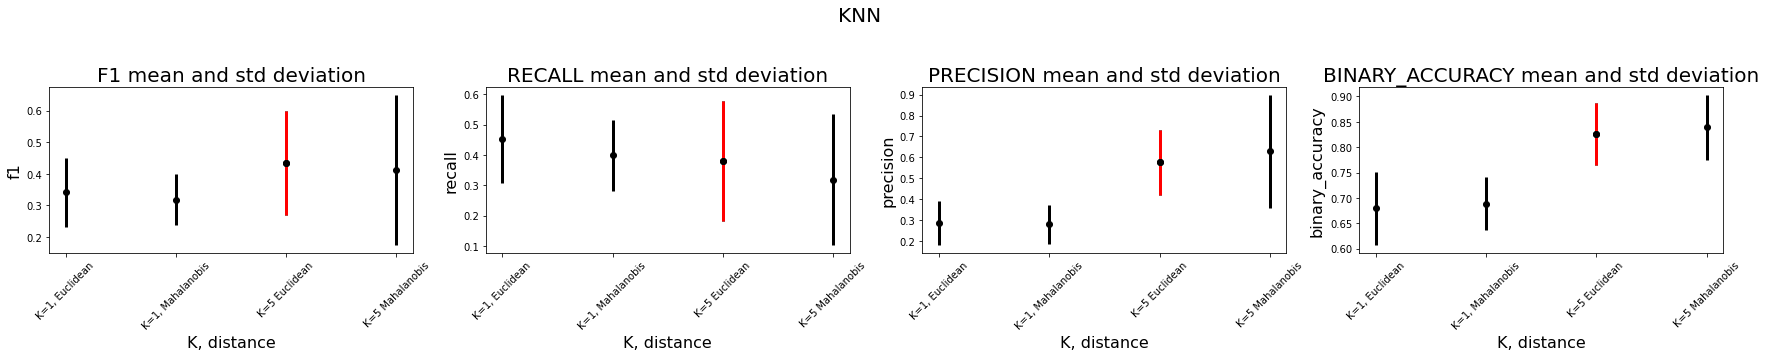

In [6]:
candidates = ["K=1, Euclidean", "K=1, Mahalanobis", "K=5 Euclidean", "K=5 Mahalanobis"]
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("KNN", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates, rotation=45)
    plt.xlabel("K, distance", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1

## Q1 a,b - Decision Trees
### Grid search with 10-fold cross-validation - hyperparameters criterion=['Entropy', 'Gini']

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

tree_grid = GridSearchCV(stats_generator=ClassificationStats)

for criterion in ['entropy', 'gini']:
    tree_grid.add(DecisionTreeClassifier, {"criterion": criterion})

tree_grid.search(X_train_scaled, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best Decision Tree:", tree_grid.best_model_params)

Best Decision Tree: {'criterion': 'entropy'}


### Performance of the best model on the **test** dataset

In [8]:
tree = tree_grid.best_model(**tree_grid.best_model_params)
tree.fit(X_train_scaled, y_train)

y_pred = tree.predict(X_test_scaled)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.8
F1-score: 0.5882352941176471


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	Entropy: 0.4202743824802647 +- 0.21943424362910868
	Gini: 0.3731591937474291 +- 0.16500865425316255
RECALL
	Entropy: 0.42832611832611833 +- 0.2544827351537479
	Gini: 0.37581890331890333 +- 0.20008699847044517
PRECISION
	Entropy: 0.44857142857142857 +- 0.23499457223432169
	Gini: 0.3958333333333333 +- 0.16472138096170444
BINARY_ACCURACY
	Entropy: 0.7940766550522648 +- 0.07173536373606715
	Gini: 0.7722415795586527 +- 0.07237915950659944


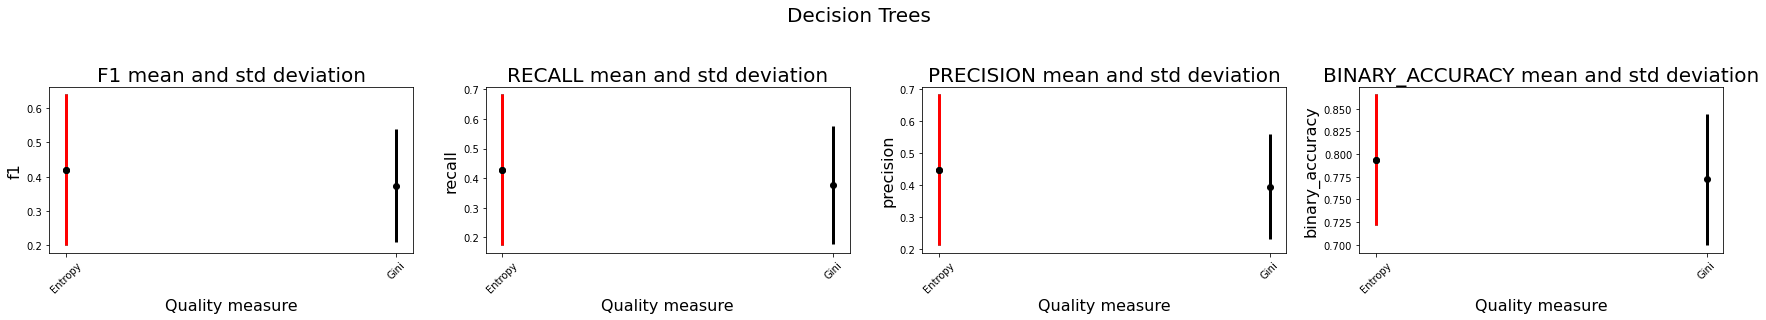

In [9]:
candidates = ["Entropy", "Gini"]
num_candidates = len(tree_grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Decision Trees", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(tree_grid.stats[i].stats["values"][metric]))
        std.append(np.std(tree_grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(tree_grid.index_of_best, means[tree_grid.index_of_best], std[tree_grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates, rotation=45)
    plt.xlabel("Quality measure", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])

    k+=1

==================================================================
==================================================================
## EXTRA

The dataset website reffered by the assignment document (https://www.openml.org/d/1063) refers to some papers which analyses this and other similar datasets.

According to [1], the KC2 dataset suffers from data quality problems, such as:
- Samples with implausible feature values
- Identical samples
- Inconsistent samples (samples that are identical but differ in their classification)
- and more

Still according to [1], removing problematic samples or features is arguable. For example, if duplicate samples exist, they might appear in both training and validation datasets, leading to an over-optimistic view of the predictive capability of a model (overfitting). However, if such duplicate cases naturaly occur (for example: similar profiles from different software), then accouting for duplicated cases can be treated as learning opportunities during training.

Thus, removing problematic samples or features depend on research goal, and researchers in [1] provide cleaned versions of the KC2 datasets for use when removing problematic data is desirable.

**So, for comparison we present results for a partially preprocessed KC2 dataset by:** 
- **Removing duplicate entries**
- **Picking one class when identical samples map to different classes**

[1] Shepperd, M. and Qinbao Song and Zhongbin Sun and Mair, C. (2013) Data Quality: Some Comments on the NASA Software Defect Datasets, IEEE Transactions on Software Engineering, 39.

## E1 - Let's remove duplicates and see how it affects our models
### **Spoiler: our models got worse at generalizing!**

In [10]:
X, y = load_csv('./datasets/kc2.csv')
original_size = X.shape[0]

X, y = load_csv('./datasets/kc2.csv', remove_duplicates=True, remove_inconsistent_labels=False)
preprocessed_size = X.shape[0]

y = y.astype(int).squeeze()
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

print(f"Samples in the original dataset: {original_size}, Samples in the preprocessed dataset: {preprocessed_size}")

Samples in the original dataset: 522, Samples in the preprocessed dataset: 375


### Our KNN implementation with K=5 and distance=Euclidean (from our previous grid search)

In [11]:
knn5 = KNN(k=5, distance=EuclideanDistance, data_scaler=MinMaxScaler)
knn5.fit(X_train, y_train)

y_pred = knn5.predict(X_test)

print("Our KNN5 - Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("Our KNN5 - F1-score:", F1Score().measure(y_test, y_pred))

Our KNN5 - Accuracy: 0.7466666666666667
Our KNN5 - F1-score: 0.45714285714285713


### SK-Learn's KNN with K=5 and distance=Euclidean

In [12]:
# Scale data with the same scaler we used during grid search
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SK-Learn's KNN with K=5 and euclidean distance
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train_scaled, y_train)

# Predict data and report performance
y_pred_sk = knn5_sk.predict(X_test_scaled)

print("SK-Learn's KNN5 - Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 - F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 - Accuracy: 0.7466666666666667
SK-Learn's KNN5 - F1-score: 0.45714285714285713


 ### SK-Learn's Decision Tree with Entropy purity criterion (from our grid search)

In [13]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train_scaled, y_train)

y_pred = tree.predict(X_test_scaled)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.64
F1-score: 0.30769230769230765


### Grid search with 10-fold cross-validation - hyperparameters K=[1, 5] and distance=['Euclidean', 'Mahalanobis']

In [14]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for k in [1, 5]:
    for distance in [EuclideanDistance, MahalanobisDistance]:
        grid.add(KNN, {"k": k, "distance": distance, "data_scaler": MinMaxScaler})

grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best KNN:", grid.best_model_params)

Best KNN: {'k': 5, 'distance': <class 'ml.functions.distance.EuclideanDistance'>, 'data_scaler': <class 'ml.algorithms.normalization.MinMaxScaler'>}


### Performance of the best model on the **test** dataset

In [15]:
knnX = grid.best_model(**grid.best_model_params)
knnX.fit(X_train, y_train)

y_pred = knnX.predict(X_test)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.7466666666666667
F1-score: 0.45714285714285713


### Performance of SKLearn's implementation on the **test** dataset with hyperparameters from grid search

In [16]:
# Scale data with the same scaler we used during grid search
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SK-Learn's KNN with K=5 and euclidean distance
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train_scaled, y_train)

# Predict data and report performance
y_pred_sk = knn5_sk.predict(X_test_scaled)

print("SK-Learn's KNN5 Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 Accuracy: 0.7466666666666667
SK-Learn's KNN5 F1-score: 0.45714285714285713


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	K=1, Euclidean: 0.5622126665604926 +- 0.0750643899316376
	K=1, Mahalanobis: 0.49496268351531514 +- 0.17357926645990962
	K=5 Euclidean: 0.610472730370092 +- 0.11643994678373618
	K=5 Mahalanobis: 0.5315856855562738 +- 0.1909262783958512
RECALL
	K=1, Euclidean: 0.6183225108225108 +- 0.12505540319391834
	K=1, Mahalanobis: 0.4696103896103896 +- 0.1640648507670376
	K=5 Euclidean: 0.5943506493506493 +- 0.16112902016756184
	K=5 Mahalanobis: 0.43937229437229436 +- 0.19617907664141826
PRECISION
	K=1, Euclidean: 0.5397005772005772 +- 0.1156708071612271
	K=1, Mahalanobis: 0.5558080808080808 +- 0.25651009996597135
	K=5 Euclidean: 0.6754184704184705 +- 0.18090339987257195
	K=5 Mahalanobis: 0.7702380952380953 +- 0.18853550042534406
BINARY_ACCURACY
	K=1, Euclidean: 0.7233333333333334 +- 0.07895146188218011
	K=1, Mahalanobis: 0.7233333333333334 +- 0.11455226851626392
	K=5 Euclidean: 0.7833333333333334 +- 0.08198915917499232
	K=5 Mahalanobis: 0.7866666666666666 +- 0.08717797887081348


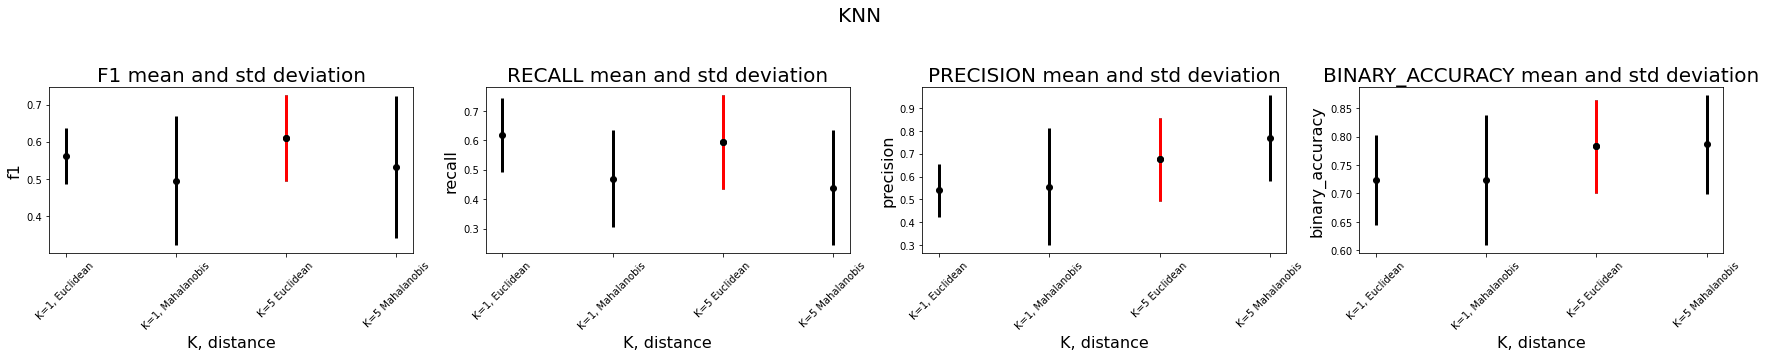

In [17]:
candidates = ["K=1, Euclidean", "K=1, Mahalanobis", "K=5 Euclidean", "K=5 Mahalanobis"]
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("KNN", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates, rotation=45)
    plt.xlabel("K, distance", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1

## E2 - Pick one class when identical samples map to different classes, remove only their duplicates
### **Spoiler: now we got really good at labeling data from this dataset!!!!** (but we are arbitrarly saying that some labels are actually wrong)

These inconsistencies really affect generalization capabilities of our models (as discussed in [1]) and whether they are correct or not is subject to business logic analysis, perhaps more features should be used so these inconsistencies woudln't occurr.

In [18]:
X, y = load_csv('./datasets/kc2.csv')
original_size = X.shape[0]

X, y = load_csv('./datasets/kc2.csv', remove_duplicates=False, remove_inconsistent_labels=True)
preprocessed_size = X.shape[0]

y = y.astype(int).squeeze()
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

print(f"Samples in the original dataset: {original_size}, Samples in the preprocessed dataset: {preprocessed_size}")

Samples in the original dataset: 522, Samples in the preprocessed dataset: 375


### Our KNN implementation with K=5 and distance=Euclidean (from our previous grid search)

In [19]:
knn5 = KNN(k=5, distance=EuclideanDistance, data_scaler=MinMaxScaler)
knn5.fit(X_train, y_train)

y_pred = knn5.predict(X_test)

print("Our KNN5 - Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("Our KNN5 - F1-score:", F1Score().measure(y_test, y_pred))

Our KNN5 - Accuracy: 1.0
Our KNN5 - F1-score: 1.0


### SK-Learn's KNN with K=5 and distance=Euclidean

In [20]:
# Scale data with the same scaler we used during grid search
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SK-Learn's KNN with K=5 and euclidean distance
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train_scaled, y_train)

# Predict data and report performance
y_pred_sk = knn5_sk.predict(X_test_scaled)

print("SK-Learn's KNN5 - Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 - F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 - Accuracy: 1.0
SK-Learn's KNN5 - F1-score: 1.0


 ### SK-Learn's Decision Tree with Entropy purity criterion (from our grid search)

In [21]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train_scaled, y_train)

y_pred = tree.predict(X_test_scaled)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 1.0
F1-score: 1.0


### Grid search with 10-fold cross-validation - hyperparameters K=[1, 5] and distance=['Euclidean', 'Mahalanobis']

In [22]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for k in [1, 5]:
    for distance in [EuclideanDistance, MahalanobisDistance]:
        grid.add(KNN, {"k": k, "distance": distance, "data_scaler": MinMaxScaler})

grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best KNN:", grid.best_model_params)

Best KNN: {'k': 1, 'distance': <class 'ml.functions.distance.EuclideanDistance'>, 'data_scaler': <class 'ml.algorithms.normalization.MinMaxScaler'>}


### Performance of the best model on the **test** dataset

In [23]:
knnX = grid.best_model(**grid.best_model_params)
knnX.fit(X_train, y_train)

y_pred = knnX.predict(X_test)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 1.0
F1-score: 1.0


### Performance of SKLearn's implementation on the **test** dataset with hyperparameters from grid search

In [24]:
# Scale data with the same scaler we used during grid search
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SK-Learn's KNN with K=5 and euclidean distance
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train_scaled, y_train)

# Predict data and report performance
y_pred_sk = knn5_sk.predict(X_test_scaled)

print("SK-Learn's KNN5 Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 Accuracy: 1.0
SK-Learn's KNN5 F1-score: 1.0


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	K=1, Euclidean: 1.0 +- 0.0
	K=1, Mahalanobis: 0.891144046012467 +- 0.07297930102046682
	K=5 Euclidean: 1.0 +- 0.0
	K=5 Mahalanobis: 0.8923291740938801 +- 0.0902441651857916
RECALL
	K=1, Euclidean: 1.0 +- 0.0
	K=1, Mahalanobis: 0.8808744033744034 +- 0.09805672948214382
	K=5 Euclidean: 1.0 +- 0.0
	K=5 Mahalanobis: 0.856940836940837 +- 0.15116655011841243
PRECISION
	K=1, Euclidean: 1.0 +- 0.0
	K=1, Mahalanobis: 0.9093253968253968 +- 0.08293579592616068
	K=5 Euclidean: 1.0 +- 0.0
	K=5 Mahalanobis: 0.9542424242424243 +- 0.07423252871591554
BINARY_ACCURACY
	K=1, Euclidean: 1.0 +- 0.0
	K=1, Mahalanobis: 0.9400000000000001 +- 0.038873012632301994
	K=5 Euclidean: 1.0 +- 0.0
	K=5 Mahalanobis: 0.9466666666666667 +- 0.04521553322083511


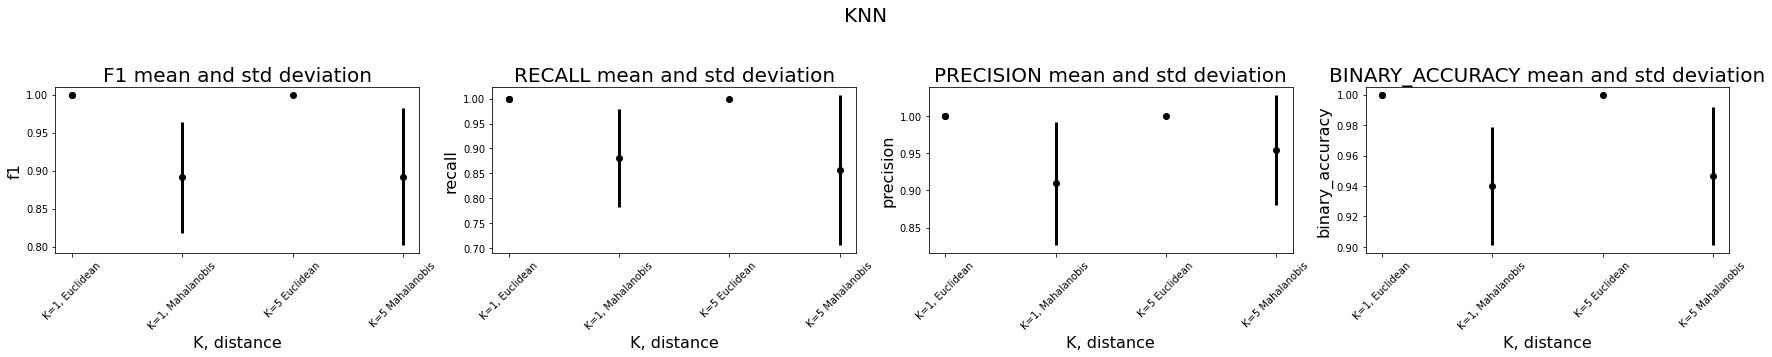

In [25]:
candidates = ["K=1, Euclidean", "K=1, Mahalanobis", "K=5 Euclidean", "K=5 Mahalanobis"]
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("KNN", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates, rotation=45)
    plt.xlabel("K, distance", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1